In [1]:
import os
from typing import List
from pydantic import BaseModel
from langchain_core.documents import Document
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_text_splitters.character import RecursiveCharacterTextSplitter
from langgraph.graph import StateGraph, END

In [2]:
from langchain_core.prompts import ChatPromptTemplate
from langchain_google_genai.chat_models import ChatGoogleGenerativeAI
import os
model = ChatGoogleGenerativeAI(
                model='gemini-2.0-flash',
                google_api_key=os.getenv('GOOGLE_API_KEY'),
                temperature=0,
                max_output_tokens=1000
            )

model.invoke('Hello')

AIMessage(content='Hello! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.0-flash', 'safety_ratings': [], 'grounding_metadata': {}, 'model_provider': 'google_genai'}, id='lc_run--e5f1785f-32e6-45bf-82d2-5e9c2409c11b-0', usage_metadata={'input_tokens': 1, 'output_tokens': 10, 'total_tokens': 11, 'input_token_details': {'cache_read': 0}})

In [3]:
from langchain_google_genai import GoogleGenerativeAIEmbeddings
import os
embeddings = GoogleGenerativeAIEmbeddings(
    model = 'models/text-embedding-004',
   google_api_key =os.getenv('GOOGLE_API_KEY')
)

embeddings


text="Hello, I am learning about embeddings!"
em = embeddings.embed_query(text)

em

[0.0057954853400588036,
 -0.020777961239218712,
 -0.073767751455307,
 0.005520607344806194,
 0.03836417198181152,
 0.008309532888233662,
 0.05843047797679901,
 0.0198830459266901,
 -0.018817421048879623,
 0.0014214477268978953,
 -0.003038973780348897,
 0.05139459669589996,
 0.0849136933684349,
 -0.017072148621082306,
 0.005389293190091848,
 -0.040984898805618286,
 0.03339604660868645,
 0.023471752181649208,
 -0.10320930182933807,
 0.04719139635562897,
 0.01596192456781864,
 -0.019129928201436996,
 0.011023784056305885,
 -0.025355495512485504,
 -0.03703681007027626,
 -0.008627268485724926,
 0.006926806177943945,
 -0.029250923544168472,
 0.015356908552348614,
 -0.01128516998142004,
 0.04638025164604187,
 0.08751466125249863,
 0.02563812956213951,
 -0.04505224898457527,
 -0.0009145495132543147,
 0.007491415832191706,
 -0.005396759137511253,
 0.015194687992334366,
 0.07375132292509079,
 -0.05054553970694542,
 -0.0762038454413414,
 0.021329674869775772,
 -0.01231074333190918,
 0.06367276608

In [15]:
docs = TextLoader("langchain_sample.txt",encoding="utf-8").load()
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
chunks = splitter.split_documents(docs)
embedding = embeddings
vectorstore = FAISS.from_documents(chunks, embedding)
retriever = vectorstore.as_retriever()

In [16]:
class RAGCoTState(BaseModel):
    question: str
    sub_steps: List[str] = []
    retrieved_docs: List[Document] = []
    answer: str = ""

In [17]:
def plan_steps(state:RAGCoTState)->RAGCoTState:
    prompt=f"Break the question into 2-3 reasoning steps: \n\n {state.question}"
    result=model.invoke(prompt).content
    subqs=[line.strip("- ") for line in result.split("\n") if line.strip()]

    return state.model_copy(update={"sub_steps":subqs})

In [18]:
def retrieve_per_step(state:RAGCoTState)-> RAGCoTState:
    all_docs=[]
    for sub in state.sub_steps:
        docs = retriever.invoke(sub)
        all_docs.extend(docs)
    return state.model_copy(update={"retrieved_docs": all_docs})

In [19]:
def generate_answer(state: RAGCoTState) -> RAGCoTState:
    
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""
You are answering a complex question using reasoning and retrieved documents.

Question: {state.question}

Relevant Information:
{context}

Now synthesize a well-reasoned final answer.
"""
    result = model.invoke(prompt).content.strip()
    return state.model_copy(update={"answer": result})

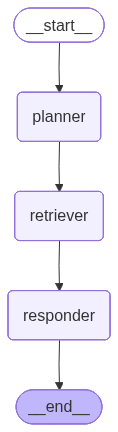

In [20]:
builder = StateGraph(RAGCoTState)
builder.add_node("planner", plan_steps)
builder.add_node("retriever", retrieve_per_step)
builder.add_node("responder", generate_answer)

builder.set_entry_point("planner")
builder.add_edge("planner", "retriever")
builder.add_edge("retriever", "responder")
builder.add_edge("responder", END)

graph = builder.compile()
graph

In [21]:
if __name__ == "__main__":
    query = "what are the additional eperiments in Transformer eveluation?"
    state = RAGCoTState(question=query)
    final = graph.invoke(state)

    print("\n🪜 Reasoning Steps:", final["sub_steps"])
    print("\n✅ Final Answer:\n", final["answer"])


🪜 Reasoning Steps: ['Okay, here\'s a breakdown of the question "What are the additional experiments in Transformer evaluation?" into reasoning steps:', '1.  **Understand the Baseline:**  First, we need to acknowledge that there are *standard* or *common* evaluation methods for Transformers.  We need to implicitly know what these are (e.g., perplexity, BLEU score on translation, accuracy on classification tasks). The question is asking for *additional* experiments, implying we already have a foundation.', "2.  **Identify Areas for Deeper Analysis:** The question implies that standard metrics might not be sufficient to fully understand a Transformer's capabilities and limitations. We need to consider what aspects of Transformer performance are *not* well-captured by basic metrics. This could include things like:", '*   **Robustness:** How well does the model perform under noisy or adversarial conditions?', "*   **Generalization:** How well does the model perform on out-of-distribution d

In [4]:
#Self reflection
import os
from typing import List
from pydantic import BaseModel
from langgraph.graph import StateGraph, END

In [6]:
docs = TextLoader("langchain_intro.txt").load()
chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
vectorstore = FAISS.from_documents(chunks, embeddings)
retriever = vectorstore.as_retriever()

In [7]:
# -------------------------
# 2. State Definition
# -------------------------
class RAGReflectionState(BaseModel):
    question: str
    retrieved_docs: List[Document] = []
    answer: str = ""
    reflection: str = ""
    revised: bool = False
    attempts: int = 0

In [8]:
def retrieve_docs(state: RAGReflectionState) -> RAGReflectionState:
    docs = retriever.invoke(state.question)
    return state.model_copy(update={"retrieved_docs": docs})

# b. Generate Answer
def generate_answer(state: RAGReflectionState) -> RAGReflectionState:
    
    context = "\n\n".join([doc.page_content for doc in state.retrieved_docs])
    prompt = f"""
Use the following context to answer the question:

Context:
{context}

Question:
{state.question}
"""
    answer = model.invoke(prompt).content.strip()
    return state.model_copy(update={"answer": answer, "attempts": state.attempts + 1})

In [10]:
def reflect_on_answer(state: RAGReflectionState) -> RAGReflectionState:
    
    prompt = f"""
Reflect on the following answer to see if it fully addresses the question. 
State YES if it is complete and correct, or NO with an explanation.

Question: {state.question}

Answer: {state.answer}

Respond like:
Reflection: YES or NO
Explanation: ...
"""
    result = model.invoke(prompt).content
    is_ok = "reflection: yes" in result.lower()
    return state.model_copy(update={"reflection": result, "revised": not is_ok})

In [11]:
def finalize(state: RAGReflectionState) -> RAGReflectionState:
    return state

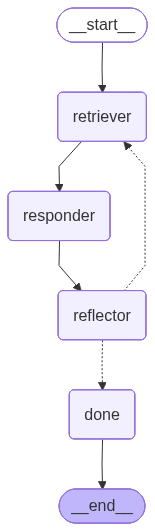

In [14]:
from typing import Literal

builder = StateGraph(RAGReflectionState)

builder.add_node("retriever", retrieve_docs)
builder.add_node("responder", generate_answer)
builder.add_node("reflector", reflect_on_answer)
builder.add_node("done", finalize)

builder.set_entry_point("retriever")

builder.add_edge("retriever", "responder")
builder.add_edge("responder", "reflector")

def decide_next_node(state: RAGReflectionState) -> Literal['done','retriever']:
    if not state.revised or state.attempts >= 2:
        return "done"
    return "retriever"

builder.add_conditional_edges("reflector", decide_next_node)



# builder.add_conditional_edges(
#     "reflector",
#     lambda s: "done" if not s.revised or s.attempts >= 2 else "retriever"
# )

builder.add_edge("done", END)
graph = builder.compile()
graph

In [ ]:
if __name__ == "__main__":
    user_query = "What are the transformer variants in production deployments?"
    init_state = RAGReflectionState(question=user_query)
    result = graph.invoke(init_state)

    print("\n🧠 Final Answer:\n", result["answer"])
    print("\n🔁 Reflection Log:\n", result["reflection"])
    print("🔄 Total Attempts:", result["attempts"])